In [1]:
# Import libraries
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os
from tqdm import tqdm
import numpy as np
import fiona
import pandas as pd 
from shapely.strtree import STRtree
from shapely.geometry import Point as SPoint

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shape - columns like name, population, elevation and the like.

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [2]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Severity, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

# Hydro River Network Database
RIVERS_PATH = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

# Create a data_plots directory
DATA_PLOTS_DIRECTORY = 'data_plots'
os.makedirs(DATA_PLOTS_DIRECTORY, exist_ok=True)

# Create output directory for Portugal grid shapefile
OUTPUT_DIRECTORY = 'output'
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

##### Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation

In [3]:
coord_ref_sys = "EPSG:25829"

### Filter out to our target area: 

Functions to load the fire data of the country we are aiming for, as well as the polygon and bounds of that country

In [4]:
from preprocessing.load_data import load_fire_data 
fire_data = load_fire_data(fire_data_path=FIRE_DATA_PATH, coord_ref_sys=coord_ref_sys)

Loaded fire dataset with 3575 unique fires


In [5]:
from preprocessing.load_data import extract_polygon, cut_size
 
mainland, mainland_polygon, minx, miny, maxx, maxy = extract_polygon(country_boundary_dataset_path=COUNTRY_BOUNDARY_PATH, country="Portugal", coord_ref_sys=coord_ref_sys)
minx, miny, maxx, maxy = cut_size(minx, miny, maxx, maxy, decrease_bottom=0.5, decrease_top=0.15, decrease_left=0, decrease_right=0)

Country bounds minx: 454235.1439060115, miny: 4077542.239783567, maxx: 718319.3451133408, maxy: 4681179.434351782
New minx: 454235.1439060115, new miny: 4590633.85516655, new maxx: 718319.3451133408, new maxy: 4590633.85516655


In [6]:
from preprocessing.load_data import create_grid
grid_size = 3000 
grid = create_grid(grid_size, mainland_polygon, coord_ref_sys, minx, miny, maxx, maxy)
grid.head() # each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

Successfully created grid!
Num nodes = 3924


,geometry
0,"POLYGON ((484235.144 4379360.837, 484235.144 4..."
1,"POLYGON ((487235.144 4379360.837, 487235.144 4..."
2,"POLYGON ((487235.144 4382360.837, 487235.144 4..."
3,"POLYGON ((490235.144 4379360.837, 490235.144 4..."
4,"POLYGON ((490235.144 4382360.837, 490235.144 4..."


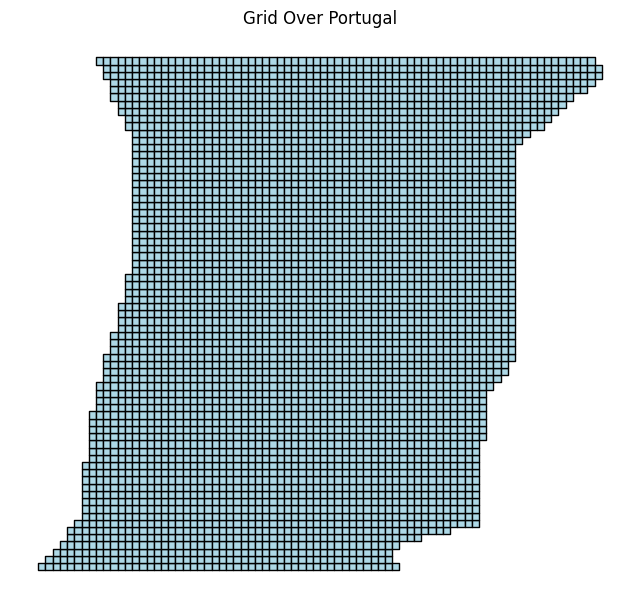

In [7]:
from visualization.preprocessing_visualization import plot_grid_to_be_used
plot_name_grid = "portugal_grid_plot.png"
plot_grid_to_be_used(grid, DATA_PLOTS_DIRECTORY, plot_name_grid, "Grid Over Portugal")

In [8]:
# saving observation area as shapefile and gpkg for better visualization in QGIS
grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.shp"))
grid.to_file(os.path.join(OUTPUT_DIRECTORY,"portugal_grid.gpkg"), layer="grid", driver="GPKG")

grid["centroid_grid"] = grid.geometry.centroid

In [9]:
from preprocessing.enrich_data import add_water_to_grid
# List of layer indices we need for our river dataset
layer_indices = [0, 1, 6, 8, 9]
grid = add_water_to_grid(grid, coord_ref_sys, RIVERS_PATH, layer_indices)

/home/vdakov/.conda/envs/graph-ml/lib/python3.13/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(
/home/vdakov/.conda/envs/graph-ml/lib/python3.13/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/home/vdakov/.conda/envs/graph-ml/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(
/home/vdakov/.conda/envs/graph-ml/lib/python3.13/site-packages/pyogrio/raw.py:198: UserWarning: Measur

Combined water bodies: (41321, 52)


In [10]:
grid = grid.reset_index(drop=True)
grid["node_id"] = np.arange(len(grid))

#### Overlay with Fire Data

Assumption - if a grid square centroid overlaps with a fire point - the node corresponding to said grid square centroid is on fire. We want to make this into a series, per date, for each fire.

In [11]:
from preprocessing.enrich_data import extract_fire_day, extract_fire_centroids
fire_data =  extract_fire_centroids(fire_data)
fire_data =  extract_fire_day(fire_data)

### Clustering for weather data

In [12]:
from preprocessing.cluster import give_cluster_grid_centers
n_clusters = 50
cluster_grid_centers, grid = give_cluster_grid_centers(n_clusters, grid, coord_ref_sys)

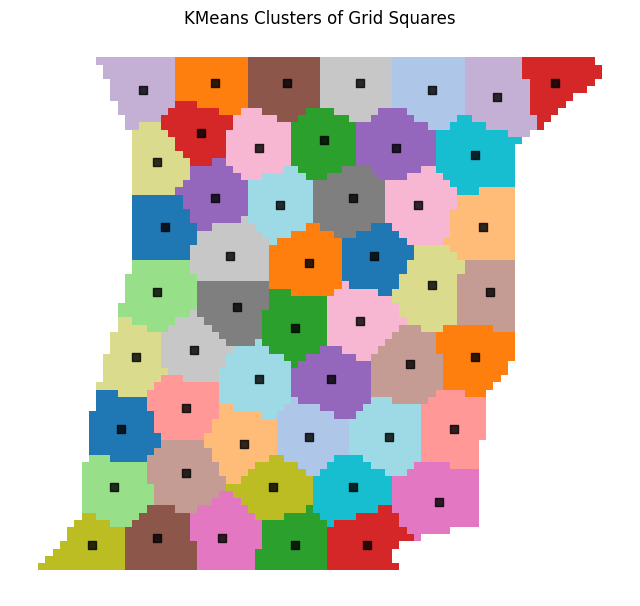

In [13]:
from visualization.preprocessing_visualization import show_clusters
show_clusters(grid, coord_ref_sys, cluster_grid_centers, DATA_PLOTS_DIRECTORY, "kmeans_clusters_grid.png")

In [14]:
from preprocessing.cluster import get_node_cluster_centroid
node_cluster = dict(zip(grid["centroid_grid"], grid["cluster_id"]))

### Aggregate Grid Based on Day

In [55]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np
from preprocessing.util import safe_stat

def enrich_with_intensity_data(graph, wildfire_severity_dir, date):
    graph["fire_intensity"] = 0
    year = str(date.year)
    for filename in os.listdir(wildfire_severity_dir):
        if filename.endswith(".tiff") and year in filename:
            filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
            with rasterio.open(filepath) as src:
                # Ensure CRS match
                if graph.crs != src.crs:
                    graph = graph.to_crs(src.crs)
                    graph["centroid_grid"] = graph.geometry.centroid
                    coords = [(geom.centroid_grid.x, geom.centroid_grid.y) for geom in graph if geom["has_fire"] == 1]
                    
                values = np.array([val[0] for val in src.sample(coords)])
                graph["fire_intensity"] = np.maximum(graph["fire_intensity"], values)
    return graph 

def split_graphs_into_days(grid:gpd.geodataframe.GeoDataFrame, fire_data:gpd.geodataframe.GeoDataFrame, num_fires_by_day:gpd.geodataframe.GeoDataFrame, wildfire_severity_dir:str):
    fire_data = fire_data.to_crs(grid.crs)
    #ensure fire_data
    graphs = []
    for day in tqdm(num_fires_by_day):
        fire_data_day = fire_data[fire_data["DAY"] == day].copy()
        graph = gpd.sjoin(grid, fire_data_day, how="left", predicate="overlaps")
        graph["has_fire"] = graph["index_right"].notna().astype(int)
        graph = enrich_with_intensity_data(graph, wildfire_severity_dir, day)
        graphs.append(graph)
        
    return graphs

In [56]:
graphs = split_graphs_into_days(grid, fire_data, fire_data["DAY"].unique(), WILDFIRE_SEVERITY_DIR)

  0%|          | 0/1278 [00:00<?, ?it/s]

 15%|█▌        | 193/1278 [00:02<00:11, 94.42it/s]UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

 16%|█▌        | 203/1278 [00:02<00:14, 76.60it/s]


TypeError: string indices must be integers, not 'str'

In [50]:
fire_data["DAY"].unique()[0].year

2016

In [ ]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np
from preprocessing.enrich_data import safe_stat

def enrich_with_intensity_data(graph, wildfire_severity_dir, date):
    graph["fire_intensity"] = 0
    year = str(date.year)
    for filename in os.listdir(wildfire_severity_dir):
        if filename.endswith(".tiff") and year in filename:
            filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
            with rasterio.open(filepath) as src:
                # Ensure CRS match
                if graph.crs != src.crs:
                    graph = graph.to_crs(src.crs)
                    graph["centroid_grid"] = graph.geometry.centroid
                    coords = [(geom.centroid_grid.x, geom.centroid_grid.y) for geom in graph if graph["has_fire"] == 1]
                values = np.array([val[0] for val in src.sample(coords)])
                graph["fire_intensity"] = np.maximum(graph["fire_intensity"], values)
    return graph 





def enrich_with_air_data(grid:gpd.geodataframe.GeoDataFrame, fire_data:gpd.geodataframe.GeoDataFrame, num_fires_by_day:gpd.geodataframe.GeoDataFrame):
    fire_data = fire_data.to_crs(grid.crs)
    graphs = []
    stop = 0
    for day in tqdm(num_fires_by_day["DAY"]):
        stop = 1
        # get fire data for this day
        fire_data_day = fire_data[fire_data["DAY"] == day].copy()

        joined = gpd.sjoin(grid, fire_data_day, how="left", predicate="intersects")

        agg = (
            joined
            .assign(_hit = joined["index_right"].notna().astype(int))
            .groupby(level=0)  # group by grid cell index
            .agg(fire_count=("index_right", "count"),
                has_fire=("_hit", "max"))
        )

        # Merge back to geometry; fill missing (no matches) with zeros
        joined_one_row = grid.join(agg, how="left").fillna({"fire_count": 0, "has_fire": 0})
        joined_one_row["fire_count"] = joined_one_row["fire_count"].astype(int)
        joined_one_row["has_fire"]   = joined_one_row["has_fire"].astype(int)

        joined_one_row["node_id"] = grid["node_id"].values
        # normalize keeps only the date, resets time to midnight (00:00:00)
        joined_one_row["DAY"] = pd.to_datetime(day).normalize()

        coords = list(zip(joined.geometry.x, joined.geometry.y))

        # Note: this method does not handle an edge case where multiple fires occurred at the same place,
        joined["fire_intensity"] = 0
        for filename in os.listdir(WILDFIRE_SEVERITY_DIR):
            if filename.endswith(".tiff"):
                filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
                with rasterio.open(filepath) as src:
                    # Ensure CRS match
                    if joined.crs != src.crs:
                        joined = joined.to_crs(src.crs)
                        joined["centroid_grid"] = joined.geometry.centroid
                        coords = [(geom.x, geom.y) for geom in joined.centroid_grid]
                    values = np.array([val[0] for val in src.sample(coords)])
                    joined["fire_intensity"] = np.maximum(joined["fire_intensity"], values)

        results = []
        i = 0
        for point, date in tqdm(zip(joined["centroid_grid"], joined["DAY"]), total=len(joined)):
            if point is None or pd.isna(date):
                continue

            # get corresponding cluster centroid
            cluster_center = get_node_cluster_centroid(point)

            if cluster_center == None:
                print("No cluster center found")
                break

            location = Point(cluster_center.y, cluster_center.x)

            # UTC timestamps for Meteostat
            start = pd.Timestamp(date)
            end = start + timedelta(days=1)

            # Fetch hourly data
            df = Hourly(location, start, end).fetch()
            if df.empty:
                i+=1

            if not df.empty:
                # Aggregate all hours in that day
                results.append({
                    "DAY": date,
                    "lat": point.y,
                    "lon": point.x,
                    "temp_mean": safe_stat(df["temp"], "mean"),
                    "rhum_mean": safe_stat(df["rhum"], "mean"),
                    "wdir_mean": safe_stat(df["wdir"], "mean"),
                    "wspd_mean": safe_stat(df["wspd"], "mean"),
                    "pres_mean": safe_stat(df["pres"], "mean"),
                })

        weather_df = pd.DataFrame(results)
        joined = pd.concat([joined, weather_df], axis=1)

        graphs.append(joined_one_row)

        if stop == 1:
            break

# graphs[0].head()

ImportError: cannot import name 'safe_stat' from 'preprocessing.enrich_data' (/home/vdakov/Desktop/courses-eternal/dsait-4305-graph-ml/Project/Full-Graph_Wildfire_Prediction/preprocessing/enrich_data.py)

## Convert to .npy format with one feature (number of wildfires)

#### Make node order identical for timeseries_data and A

In [ ]:
# Create a node index
node_index = (grid_gdf[["node_id"]]
              .drop_duplicates()
              .sort_values("node_id")
              .set_index("node_id")
              .index)

assert grid_gdf.crs and not grid_gdf.crs.is_geographic, "Grid must be in a projected CRS (meters)."

# Reorder grid_gdf to this canonical order so the distance matrix uses the same row order
grid_gdf = (grid_gdf
            .drop_duplicates(subset="node_id")
            .set_index("node_id")
            .loc[node_index]
            .reset_index())

assert grid_gdf["node_id"].is_unique, "node_id must be unique after dedup."

#### Distance Matrix

In [ ]:
cent = grid_gdf.geometry.centroid
N = len(cent)
A = np.zeros(shape = (N, N))

grid_points = grid_gdf["geometry"].to_numpy()
P1s = np.array(list(map(lambda x: np.array([x.centroid.x, x.centroid.y]), grid_points[:] )))
P2s = np.array(list(map(lambda x: np.array([x.centroid.x, x.centroid.y]), grid_points[:] )))

A = np.sum((P1s[:,None,:] - P2s[None,:,:])**2, axis=2)**0.5
np.fill_diagonal(A, 0.0)   # ensure exact zero self-distances

In [ ]:
np.save("data/distance_matrix.npy", A)

In [ ]:
# Sanity check to make sure the dist is in meters, not latitude
assert grid_gdf.crs and not grid_gdf.crs.is_geographic

#### Timeseries Data

In [ ]:
# Construct Timeseries Data
# Concatenate all days into one long table (keep only what we need)
long = pd.concat(
    [
        g[["node_id", "fire_count", "DAY"]].copy()
          .assign(DAY=pd.to_datetime(g["DAY"]).dt.normalize())  # ensure consistent dtype
        for g in graphs
    ],
    axis=0,
    ignore_index=True
)

# If any duplicates slipped in per (node_id, DAY), sum them:
long = (long
        .groupby(["node_id", "DAY"], as_index=False)["fire_count"]
        .sum())

# Create sorted day index
day_index = (long["DAY"]
             .dropna()
             .sort_values()
             .unique())

#Pivot to wide matrix (N x T), fill missing vals with 0:
wide = (long
        .pivot_table(index="node_id", columns="DAY", values="fire_count", aggfunc="sum", fill_value=0)
        .reindex(index=node_index, columns=day_index, fill_value=0)
        .sort_index(axis=0)
        .sort_index(axis=1))

#Final (N,T) float32 array:
timeseries_data = wide.to_numpy(dtype=np.float32)  # shape (10041, 1284)

np.save("data/timeseries_data.npy", timeseries_data)
np.save("data/days.npy", day_index.astype("datetime64[ns]"))
# grid_gdf[["centroid_x_grid", "centroid_y_grid"]].describe()


In [ ]:
# Final sanity checks for adjacency matrices
N = len(node_index)
assert A.shape == (N, N), "Distance matrix shape mismatch."
assert np.allclose(A, A.T), "Distance matrix must be symmetric."
assert timeseries_data.shape[0] == N, "Timeseries row count must match nodes."
assert np.isfinite(timeseries_data).all(), "Timeseries contains non-finite values."

## Clustering grid squares in terms of weather data to reduce number of API calls

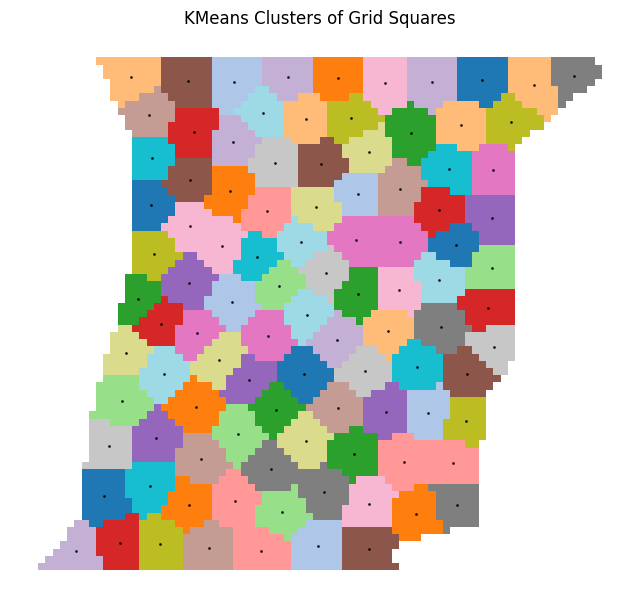

,node_id,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,cluster_id
0,0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),482735.143906,4.380861e+06,9366.776304,48
1,1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),485735.143906,4.380861e+06,7024.423788,48
2,2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),485735.143906,4.383861e+06,7587.118789,48
3,3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),488735.143906,4.380861e+06,4022.630401,48
4,4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),488735.143906,4.383861e+06,4895.181952,48


In [ ]:
from sklearn.cluster import KMeans

grid_gdf.to_crs(coord_ref_sys)
coords = np.array([(geom.y, geom.x) for geom in grid_gdf.centroid_grid])

# clustering based on geographic closeness
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
grid_gdf["cluster_id"] = kmeans.fit_predict(coords)

fig, ax = plt.subplots(figsize=(8, 8))
grid_gdf.plot(column="cluster_id", categorical=True, ax=ax, cmap="tab20")

cluster_centers = kmeans.cluster_centers_
cluster_points = gpd.GeoDataFrame(
    geometry = [SPoint(xy[1], xy[0]) for xy in cluster_centers],
    crs = coord_ref_sys
)

cluster_points.plot(ax=ax, color="black", markersize=1, alpha=0.8)
ax.set_title("KMeans Clusters of Grid Squares")
ax.set_axis_off()
plt.savefig(os.path.join(DATA_PLOTS_DIRECTORY, "kmeans_weather.png"), dpi=300, bbox_inches="tight")
plt.show()

grid_gdf.head()

In [ ]:
from meteostat import Point, Hourly
from datetime import timedelta

start = pd.Timestamp(fire_data["DAY"].min())
end = pd.Timestamp(fire_data["DAY"].max() + timedelta(days=1))

cluster_weather = []

for cluster_id, group in grid_gdf.groupby("cluster_id"):
    # Fetch weather data for each cluster (instead of every grid square)
    lat = group.geometry.centroid.y.mean()
    lon = group.geometry.centroid.x.mean()

    # fetch weather data for the full date range
    df_weather = Hourly(Point(lat, lon), start, end).fetch()

    if not df_weather.empty:
        daily = df_weather.resample("D").mean().reset_index() # daily mean
        daily["DAY"] = daily["time"].dt.date
        daily["cluster_id"] = cluster_id
        # temperature, relative humidity, wind direction, wind speed, air pressure
        cluster_weather.append(daily[["cluster_id", "DAY", "temp", "rhum", "wdir", "wspd", "pres"]])

weather_df = pd.concat(cluster_weather, ignore_index=True)
weather_df.to_csv(os.path.join(DATA_PLOTS_DIRECTORY, "cluster_weather.csv"), index=False)

weather_df.head()

,cluster_id,DAY,temp,rhum,wdir,wspd,pres
0,0,2019-11-04,5.566667,78.666667,13.5,1.2,1033.766667
1,0,2019-11-05,5.65,63.416667,68.625,5.620833,1031.7375
2,0,2019-11-06,6.245833,50.0,94.875,5.3,1026.654167
3,0,2019-11-07,8.670833,42.416667,87.958333,4.679167,1024.075
4,0,2019-11-08,8.558333,49.166667,64.73913,3.825,1026.475


### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.


In [ ]:
# A summary and sample of the graphs list - + persistence
import pickle
with open('output/graphs.pkl', 'wb') as f:
    pickle.dump(graphs, f)
    
print("Number of time steps(graphs)", len(graphs))
print("Example graph for one day:")
graphs[0]

Number of time steps(graphs) 1278
Example graph for one day:


,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,node_id,fire_count,has_fire,DAY
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),482735.143906,4.380861e+06,9366.776304,0,0,0,2016-05-01
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),485735.143906,4.380861e+06,7024.423788,1,0,0,2016-05-01
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),485735.143906,4.383861e+06,7587.118789,2,0,0,2016-05-01
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),488735.143906,4.380861e+06,4022.630401,3,0,0,2016-05-01
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),488735.143906,4.383861e+06,4895.181952,4,0,0,2016-05-01
...,...,...,...,...,...,...,...,...,...
3919,"POLYGON ((712235.144 4583360.837, 712235.144 4...",POINT (710735.144 4584860.836),710735.143906,4.584861e+06,91463.864312,3919,0,0,2016-05-01
3920,"POLYGON ((712235.144 4586360.837, 712235.144 4...",POINT (710735.144 4587860.836),710735.143906,4.587861e+06,93926.132309,3920,0,0,2016-05-01
3921,"POLYGON ((712235.144 4589360.837, 712235.144 4...",POINT (710735.144 4590860.836),710735.143906,4.590861e+06,96418.506215,3921,0,0,2016-05-01
3922,"POLYGON ((715235.144 4583360.837, 715235.144 4...",POINT (713735.144 4584860.836),713735.143906,4.584861e+06,89720.357593,3922,0,0,2016-05-01


## Attempt to Convert to .npy Format for the Models

In [ ]:
# date_col = "FIREDATE"   # adjust to your real column name
# fire_data[date_col] = pd.to_datetime(fire_data[date_col]).dt.normalize()
# full_days = pd.date_range(
#     fire_data[date_col].min(),
#     fire_data[date_col].max(),
#     freq="D"
# )